# Générer des réalisations d'une variable aléatoire par inversion de la fonction de répartition

## Introduction

Dans cette page, nous présentons comment générer des des réalisations d'une variable aléatoire par inversion de la fonction de répartition. Cette méthode de génération n'est presque pas utilisée en pratique, pour des raisons à la fois de performance, de qualité des nombres aléatoires générés et de précision numérique lorsqu'on réalise les calculs avec des nombres à virgule flottante. Toutefois, elle a un intérêt pédagogique, car elle permet d'observer la distribution des nombres générés.

## Application à la loi de Weibull

Soient $\beta>0$ et $\alpha>0$ deux paramètres réels : $\beta$ est un paramètre de forme et $\alpha$ est un paramètre d'échelle.
La fonction de répartition de la loi de Weibull est :
$$
F(x) = 1 - \exp\left(-\frac{x}{\alpha}\right)^\beta,
$$
pour $x\geq 0$.

Dans d'autres contextes, les paramètres sont notés $k=\beta$ et $\lambda=\alpha$.

L'inverse de la fonction de répartition est :
$$
F^{-1}(x) = \alpha \left(-\log(1-p)\right)^{\frac{1}{\beta}}
$$
pour $x\geq 0$.
Cette fonction est souvent nommée fonction $quantile$, car elle calcule le quantile $F^{-1}(x)$ en fonction d'une observation $x$.

## Perte de précision si p est proche de 1

En pratique, il s'avère que, si la probabilité $p$ est très proche de 1, alors $1-p$ est très proche de zéro. Cela peut entraîner une forte perte de précision lors de l'évaluation de la soustraction $1-p$ avec des nombres à virgule flottante, car 1 et $p$ ont beaucoup de chiffres communs lorsque $p$ est très proche de 1. Le phénomène associé à un tel calcul est la *perte de chiffres significatifs par cancellation*, une difficulté tout à fait récurrente dans ce contexte. 

Pour la fonction de répartition, on peut utiliser la fonction $\textrm{expm1}$, définie par :
$$
\textrm{expm1}(x) = \exp(x)-1,
$$
pour tout $x\in\mathbb{R}$.
La fonction de répartition est :
$$
F(x) = -\textrm{expm1} \left(\left(-\frac{x}{\alpha}\right)^\beta\right),
$$
pour $x\geq 0$.

Pour l'inverse de la fonction de répartion, on peut utiliser la fonction $\textrm{log1p}$, définie par :
$$
\textrm{log1p}(x) = \log(1+x)
$$
si $x>-1$.

L'inverse de la fonction de répartition est :
$$
F^{-1}(x) = \alpha \left(-\textrm{log1p}(-p)\right)^{\frac{1}{\beta}}
$$
pour $x\geq 0$.

Dans la suite de ce texte, on n'évoquera plus cette difficulté.

## Génération par inversion : histogramme et densité

In [1]:
import openturns as ot
import numpy as np

In [2]:
def weibullQ(p,alpha,beta):
    '''Fonction quantile de la loi de Weibull'''
    x = alpha*(-np.log1p(-p))**(1/beta)
    return x

Dans OpenTURNS, la loi uniforme par défaut est entre -1 et 1. C'est pourquoi on spécifie explicitement les bornes.

In [3]:
U = ot.Uniform(0.,1.)

On génère un échantillon de taille n=1000 de la loi uniforme entre 0 et 1.

In [4]:
n = 1000
sample = U.getSample(n)

On définit les paramètres de la loi de Weibull.

In [5]:
alpha = 1.0
beta = 10.

On convertit l'échantillon en `array` numpy, puis on applique la fonction quantile de la loi de Weibull.

In [6]:
p = np.array(sample)
x = weibullQ(p,alpha,beta)

Pour comparer, on utilise la classe `Weibull` (en utilisant la valeur par défaut du paramètre de position $\gamma=0$).

In [7]:
W = ot.Weibull(alpha,beta)

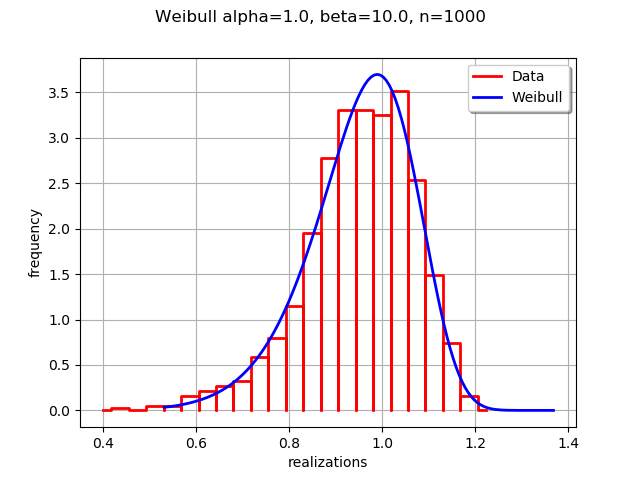

In [8]:
histo = ot.HistogramFactory().build(x).drawPDF()
histo.setTitle("Weibull alpha=%s, beta=%s, n=%d" % (alpha,beta,n))
histo.setLegends(["Data"])
wpdf = W.drawPDF()
wpdf.setColors(["blue"])
wpdf.setLegends(["Weibull"])
histo.add(wpdf)
histo

## Observation des quantiles

In [9]:
n = 50
sample = U.getSample(n)

In [10]:
p = np.array(sample)
x = weibullQ(p,alpha,beta)

On trie des données par ordre croissant.

In [11]:
data = ot.Sample(n,2)
data[:,0] = x
data[:,1] = p
data.setDescription(["x","p"])

In [12]:
data = ot.Sample(data.sort())
data[0:5,:]

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=2 description=[x,p] data=[[0.615941,0.00782864],[0.673874,0.0191248],[0.719489,0.0364919],[0.736822,0.0460705],[0.741149,0.0487797]]

In [13]:
x = data[:,0]
p = data[:,1]

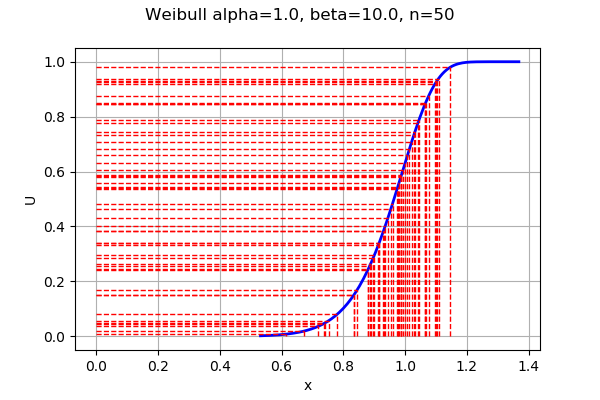

In [14]:
graph = ot.Graph("Weibull alpha=%s, beta=%s, n=%s" % (alpha,beta,n),"x","U",True)
# Ajoute la fonction de répartition
curve = W.drawCDF()
curve.setColors(["blue"])
graph.add(curve)
# Ajoute les traits horizontaux
for i in range(n):
    curve = ot.Curve([0.,x[i,0]],[p[i,0],p[i,0]])
    curve.setColor("red")
    curve.setLineStyle("dashed")
    graph.add(curve)
# Ajoute les traits verticaux
for i in range(n):
    curve = ot.Curve([x[i,0],x[i,0]],[0.,p[i,0]])
    curve.setColor("red")
    curve.setLineStyle("dashed")
    graph.add(curve)
graph

On observe que la distribution des traits verticaux (sur l'axe X) est celle de la loi de Weibull. La distribution des traits horizontaux (sur l'axe U) suit la loi uniforme.